In [2]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import importlib

In [22]:
save_plots = True

## Peak Delay, DCM and speed regression

Contents:
Self explanatory title

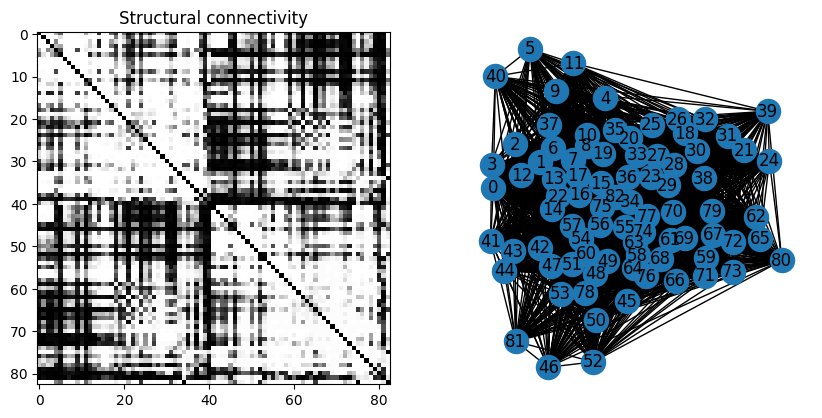

In [5]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj = np.nan_to_num(adj)[:83,:83]
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### From peak delay

In [28]:
with open('../resources/peak_delay__median.txt') as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [29]:
max_path_depth = 3
adj_reduced = utils.deepcopy(adj)

a = 0.85
alpha = [a**(i+1) for i in range(max_path_depth)]

design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

# Solver
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=True, 
                                            early_stop=1e-10, step_size=1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 1337.8303159476743
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 1000 #######
datafit loss: 1314.3478950857884
L2 norm: 56.93881121619904
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 1298.4884039521314
L2 norm: 72.55443167773133
positivity loss: 0.0

###### ITER 3000 #######
datafit loss: 1283.1078121701187
L2 norm: 87.70544326517074
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 1268.2014556415627
L2 norm: 102.39595717210804
positivity loss: 0.0

###### ITER 5000 #######
datafit loss: 1253.7641680133434
L2 norm: 116.63058414222378
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 1239.790296992174
L2 norm: 130.41442023572043
positivity loss: 0.0

###### ITER 7000 #######
datafit loss: 1226.2737230997561
L2 norm: 143.7530301088724
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 1213.207880705429
L2 norm: 156.65242795071052
positivity loss: 0.0

###### ITER 9000 #######
datafit loss:

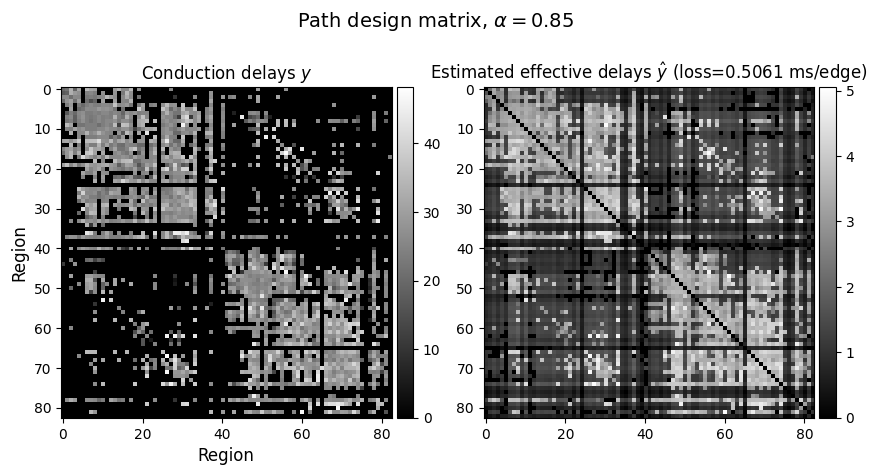

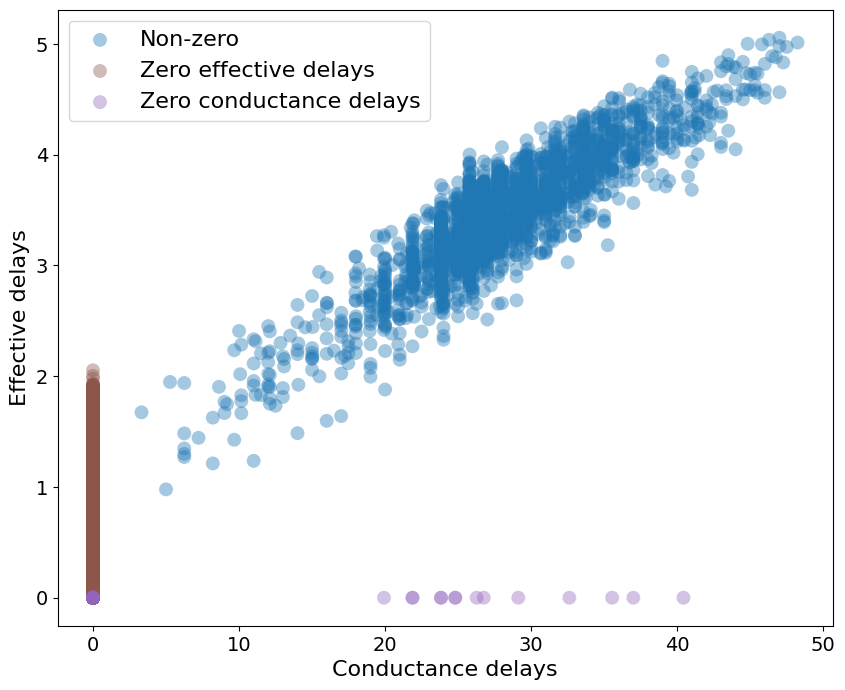

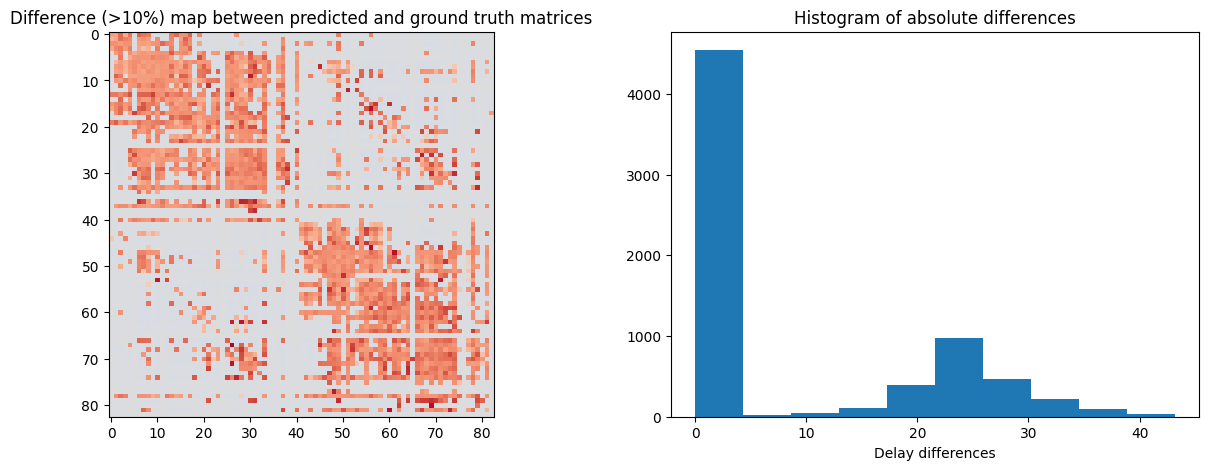

In [32]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective delays $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

if save_plots:
    fig.savefig(f"../figures/estimated_delays_a{a}_peak.png", dpi=300)
plt.show()

x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)

if save_plots:
    fig.savefig("../figures/scatter-effective_conductance_peak.png", dpi=300)

plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

plt.show()

### From conductance delay (DCM)

In [34]:
with open('../resources/dcm_axonal_delay__median.txt') as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [35]:
max_path_depth = 3
adj_reduced = utils.deepcopy(adj)

a = 0.85
alpha = [a**(i+1) for i in range(max_path_depth)]

design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

# Solver
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=True, 
                                            early_stop=1e-10, step_size=1, delta=0,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 465.5603588323794
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 1000 #######
datafit loss: 489.2145039125308
L2 norm: 4.16989864190079
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 490.10045717349556
L2 norm: 3.1874093100140777
positivity loss: 0.0

###### ITER 3000 #######
datafit loss: 490.98406875772594
L2 norm: 2.207861395373634
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 491.8651445618873
L2 norm: 1.2314659235498635
positivity loss: 0.0

###### ITER 5000 #######
datafit loss: 488.81743532094487
L2 norm: 16.656491544507638
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 485.2425785066867
L2 norm: 11.412127868300557
positivity loss: 0.0

###### ITER 7000 #######
datafit loss: 484.94488512089714
L2 norm: 9.31096749579654
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 485.6638415773289
L2 norm: 8.150624896250667
positivity loss: 0.0

###### ITER 9000 #######
datafit loss: 486.

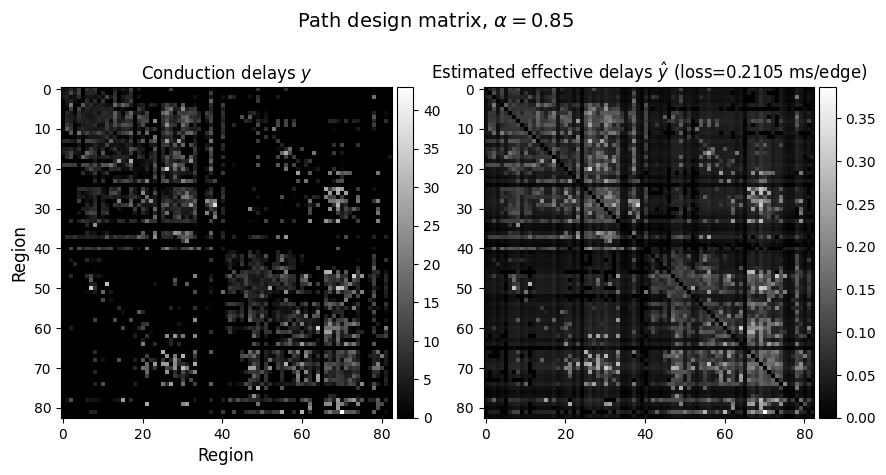

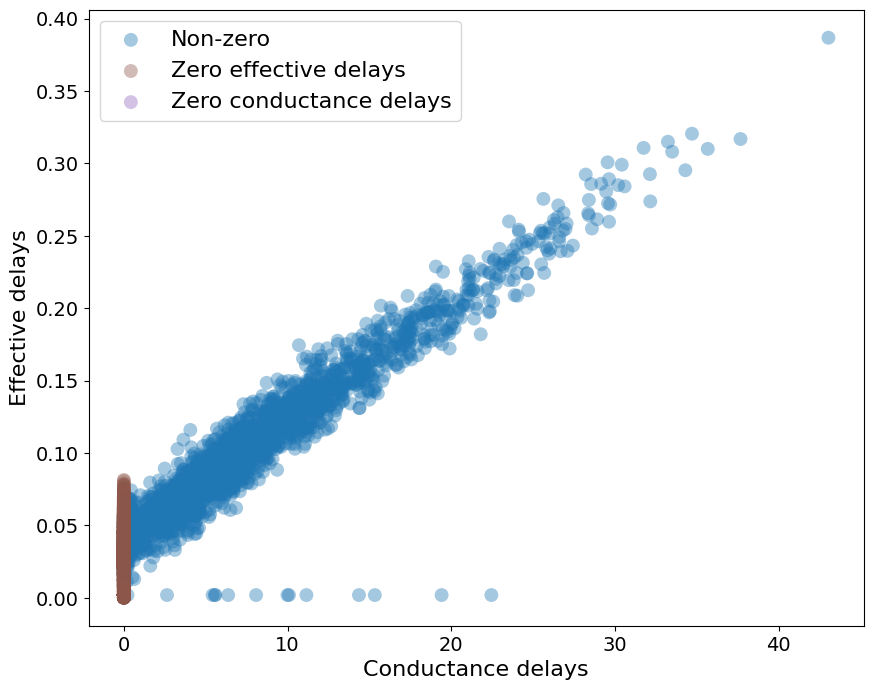

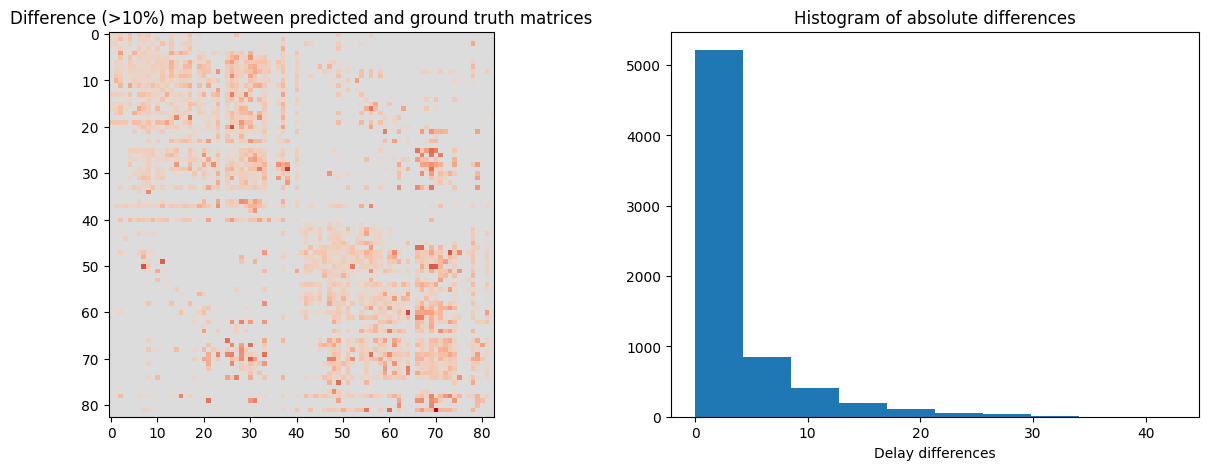

In [36]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective delays $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

if save_plots:
    fig.savefig(f"../figures/estimated_delays_a{a}_dcm.png", dpi=300)
plt.show()

x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)

if save_plots:
    fig.savefig("../figures/scatter-effective_conductance_dcm.png", dpi=300)

plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

plt.show()

### From conductance speed (DCM) 

In [37]:
with open('../resources/speed__fibres__dcm_axonal_delay__median.txt') as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [38]:
max_path_depth = 3
adj_reduced = utils.deepcopy(adj)

a = 0.85
alpha = [a**(i+1) for i in range(max_path_depth)]

design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

# Solver
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=True, 
                                            early_stop=1e-10, step_size=1, delta=0,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 8533.197110230998
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 1000 #######
datafit loss: 8522.773214517481
L2 norm: 48.5362784322103
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 8529.976830024452
L2 norm: 19.110398065845505
positivity loss: 0.0

###### ITER 3000 #######
datafit loss: 8528.333532109304
L2 norm: 22.822757821416385
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 8539.396845226645
L2 norm: 18.042702879918544
positivity loss: 0.0

###### ITER 5000 #######
datafit loss: 8539.103154732142
L2 norm: 2.283344702987549
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 8537.690374826947
L2 norm: 6.444195559376066
positivity loss: 0.0

###### ITER 7000 #######
datafit loss: 8522.68036977437
L2 norm: 52.46840530746615
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 8522.717794958253
L2 norm: 58.02890409474667
positivity loss: 0.0

###### ITER 9000 #######
datafit loss: 8527.2056

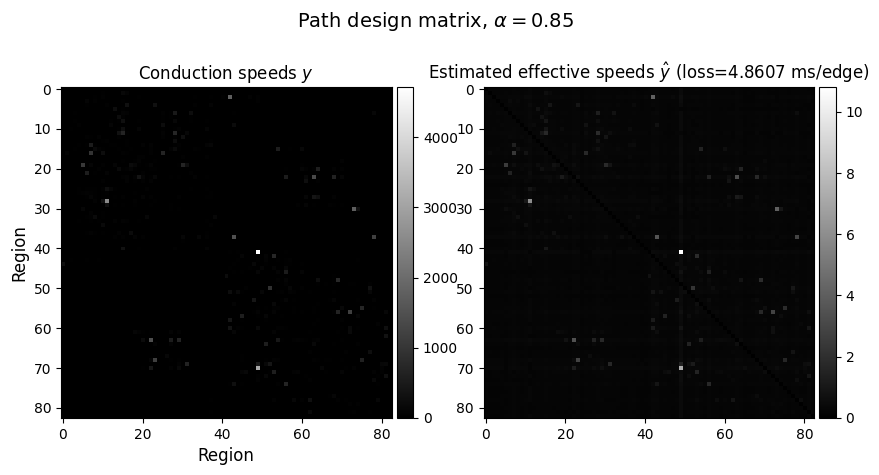

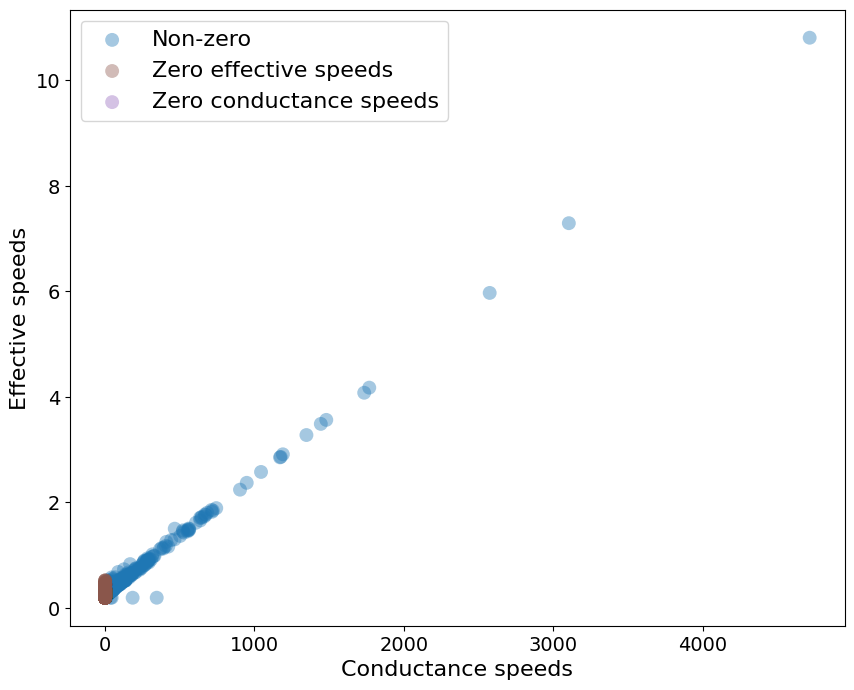

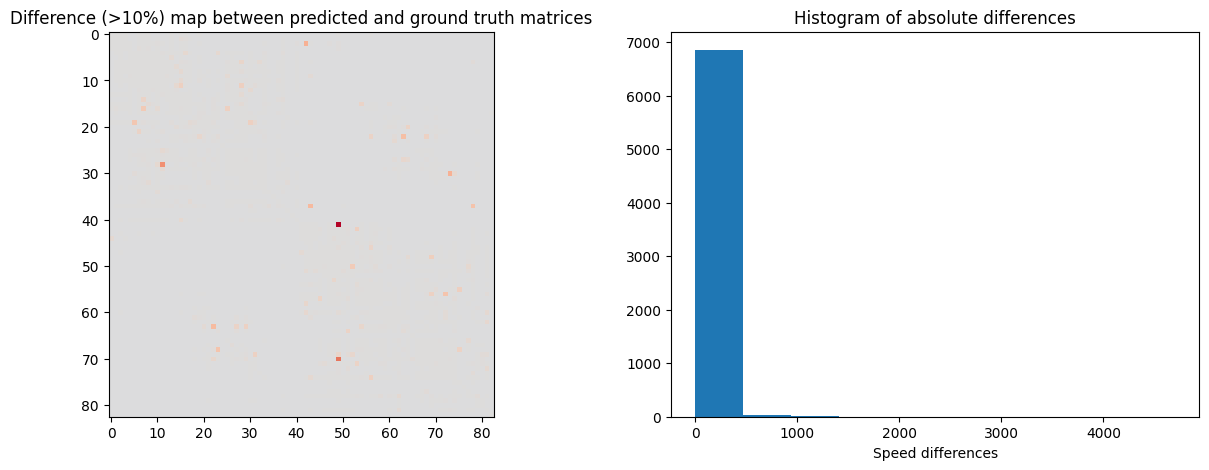

In [39]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction speeds $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective speeds $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

if save_plots:
    fig.savefig(f"../figures/estimated_speeds_a{a}_dcm.png", dpi=300)
plt.show()

x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance speeds", fontsize=16)
ax.set_ylabel("Effective speeds", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective speeds", "Zero conductance speeds"], fontsize=16)

if save_plots:
    fig.savefig("../figures/scatter-effective_conductance_speed_dcm.png", dpi=300)

plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Speed differences')

plt.show()

### From conductance speed (peak) 

In [41]:
with open('../resources/speed__fibres__peak_delay__median.txt') as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [42]:
max_path_depth = 3
adj_reduced = utils.deepcopy(adj)

a = 0.85
alpha = [a**(i+1) for i in range(max_path_depth)]

design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

# Solver
np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=True, 
                                            early_stop=1e-10, step_size=1, delta=0,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 88.73147489770986
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 1000 #######
datafit loss: 102.45037962472927
L2 norm: 8.890699846999608
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 103.83038582595643
L2 norm: 5.492185029551096
positivity loss: 0.0

###### ITER 3000 #######
datafit loss: 105.89125069661692
L2 norm: 2.7718131220889437
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 106.47011124303555
L2 norm: 19.062979508875287
positivity loss: 0.0

###### ITER 5000 #######
datafit loss: 102.60274018984074
L2 norm: 10.605774083370742
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 103.20431867732596
L2 norm: 6.467118473995519
positivity loss: 0.0

###### ITER 7000 #######
datafit loss: 105.19809626580553
L2 norm: 3.665933090483366
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 107.27086626412391
L2 norm: 0.9998783039706272
positivity loss: 0.0

###### ITER 9000 #######
datafit loss

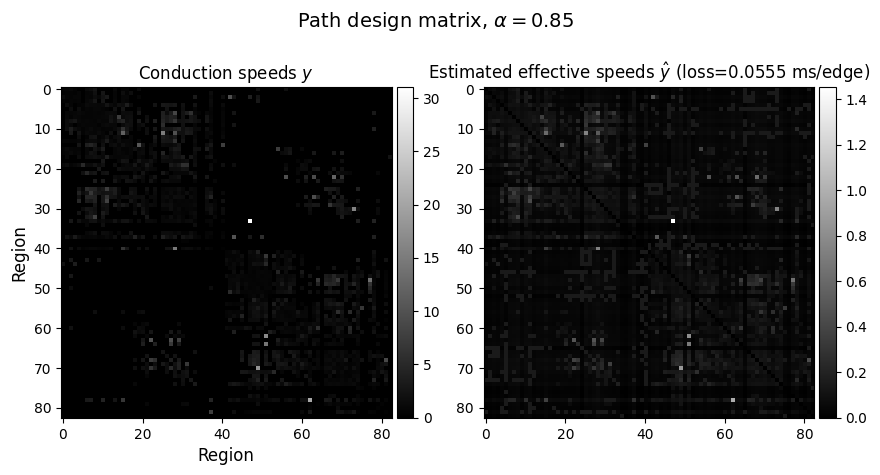

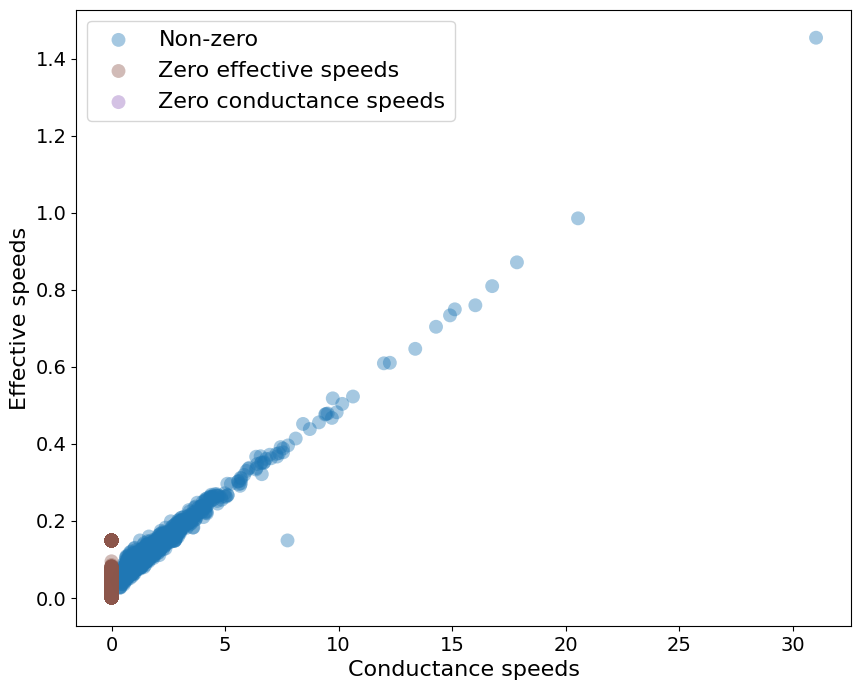

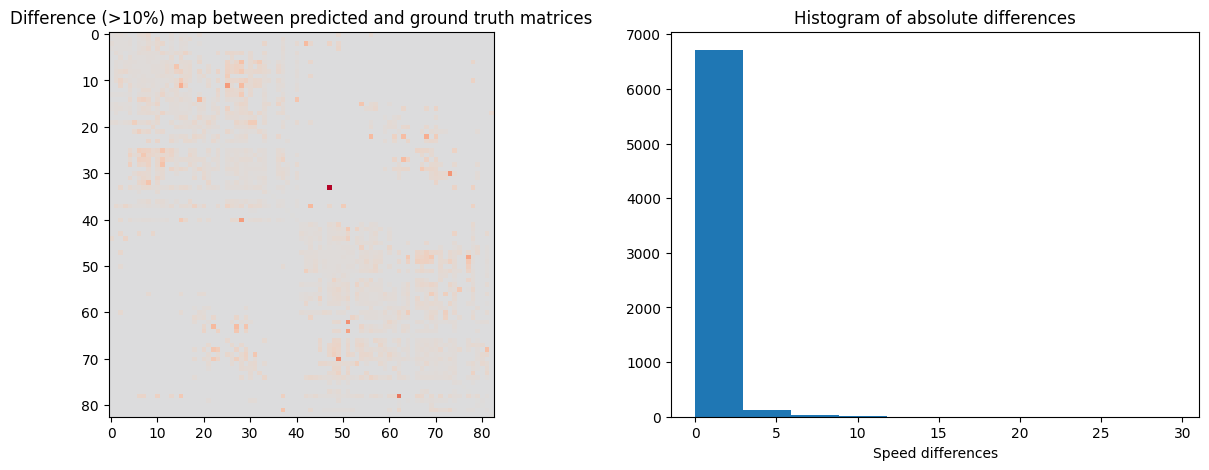

In [43]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction speeds $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective speeds $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

if save_plots:
    fig.savefig(f"../figures/estimated_speeds_a{a}_peak.png", dpi=300)
plt.show()

x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance speeds", fontsize=16)
ax.set_ylabel("Effective speeds", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective speeds", "Zero conductance speeds"], fontsize=16)

if save_plots:
    fig.savefig("../figures/scatter-effective_conductance_speed_peak.png", dpi=300)

plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Speed differences')

plt.show()